# Preprocessing 

### Importing and Iterating 
- After loading in the cleaned and combined data I checked to make sure all values were present. It seems that the null values that I replaced with empty strings got recognized as null values when loading in the data. This fillna process will have to be implemented at the start of each notebook. 
- For my initial iteration I only filtered out any links and non alpha-numeric characters. Links are unique and uninformative for our problem because they offer no characteristics of the subreddit and are none identifiable as words. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
import re 
from nltk.corpus import stopwords
import spacy

In [2]:
# read in data 
both_subs = pd.read_csv('../data/both_subreddits.csv')
# ensure all values are filled 
both_subs['text'] = both_subs['text'].fillna('')

In [3]:
# check for missing values 
both_subs.isnull().sum()

title               0
text                0
subreddit           0
name                0
text_length         0
text_word_length    0
title_text          0
dtype: int64

In [4]:
# Filter out links 
both_subs['title_text'] = [re.sub('https?.*', '', post) \
                               for post in both_subs['title_text']]
both_subs['title_text'] = [re.sub('www.*', '', post) \
                               for post in both_subs['title_text']]

In [5]:
# Filter out non alpha-numeric characters 
tokenizer = RegexpTokenizer(r'\w+')
new_col = []
for i in both_subs['title_text']:
    ls = tokenizer.tokenize(i.lower())
    string = ' '.join(ls)
    new_col.append(string)
both_subs['reg_text'] = new_col

In [6]:
both_subs['title_text'][0]

'My Mother\'s Russian NeighbourSo this story isn\'t mine but my mother\'s from when she was in her early 20s.\n\nShe had a pet cat she named Octopus, she also had a Russian neighbor that lived next door. One day he\'s over for some reason and picks up her cat and goes "why you call him Octopus? He\'s cat! See, four legs!"\n\nAnd my Mom goes "Because. Octo-**pus**"\n\nThe neighbour then says "but he no Octopus he cat! See four legs, not eight. He cat"\n\n"No-no. In English, pussy cat is another word for cat. So I called him Octo-**pus**"\n\n"No-no he cat. He have 4 legs, count them. 1-2-3-4. Not 8, 4 legs, he cat!"\n\n"No. Octo-**pus**. Pussy cat, puss"\n\n"BUT HE HAVE FOUR LEGS. HE CAT!"'

In [7]:
# first iteration is assigned to a new column so we can go between different iterations easily. 
both_subs['reg_text'][0]

'my mother s russian neighbourso this story isn t mine but my mother s from when she was in her early 20s she had a pet cat she named octopus she also had a russian neighbor that lived next door one day he s over for some reason and picks up her cat and goes why you call him octopus he s cat see four legs and my mom goes because octo pus the neighbour then says but he no octopus he cat see four legs not eight he cat no no in english pussy cat is another word for cat so i called him octo pus no no he cat he have 4 legs count them 1 2 3 4 not 8 4 legs he cat no octo pus pussy cat puss but he have four legs he cat'

- When comparing the original text with the filtered RegExp text we can see all non-alphanumeric values are gone. 

### Analyzing Word Frequency 
- For my first matrix I used the established stop words with no added customization. When looking at the top most frequent individual words we can see that the RegexpTokenizer has split words based on apostrophes. This will give us half words such as 'don', 've', and 'didn' that make it difficult to interpret. 


In [40]:
def count_vec_1(data, x_col):  
    X = data[x_col]
    y = data['subreddit']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    c_v_1 = CountVectorizer(stop_words='english', ngram_range=(1, 1))
    c_v_1.fit(X_train)
    X_1 = c_v_1.transform(X_train)
    X_1_df = pd.DataFrame(X_1.todense(), 
                          columns=c_v_1.get_feature_names_out())
    X_1_df.drop(columns=['subreddit'], axis = 1, inplace=True)
    return X_1_df

In [41]:
X_1_df = count_vec_1(both_subs, 'reg_text')

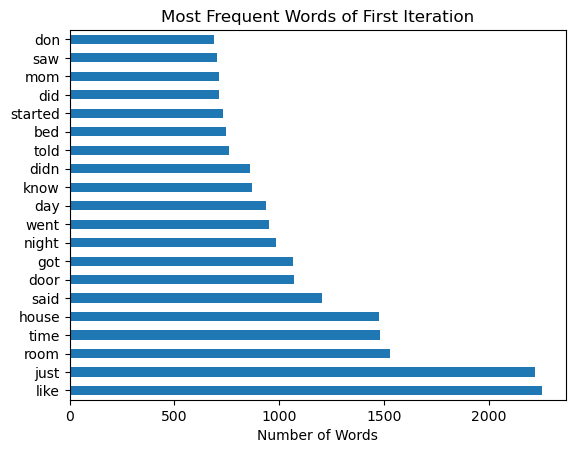

In [61]:
X_1_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Most Frequent Words of First Iteration')
plt.xlabel('Number of Words');
plt.savefig('../images/first_it_top_w.png')

In [11]:
custom_stop = stopwords.words('english')
new_words = ['ve', 'don', 'amp', 'x200b', 'just', 'didn', 'house', 'time', 'said', 'isn']
custom_stop.extend(new_words)


- Before adding custom stop words, the most frequent bi and trigrams had 'amp' or 'x200b' within it. After looking through some individual posts it was clear this was a coded filler text. I also decided to add 'just', 'house', 'time', and 'said' to my custom stop words because it was the most frequent individual word yet did not show up nearly as much in the bi and trigrams. This tells me this is just a common overlap word with no important context before or after. 

In [43]:
def count_vec_2(data):
    X = data['reg_text']
    y = data['subreddit']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    c_v_2 = CountVectorizer(stop_words=custom_stop, ngram_range=(2, 2))
    c_v_2.fit(X_train)
    X_2 = c_v_2.transform(X_train)
    X_2_df = pd.DataFrame(X_2.todense(), 
                          columns=c_v_2.get_feature_names_out())
    return X_2_df

In [44]:
X_2_df = count_vec_2(both_subs)

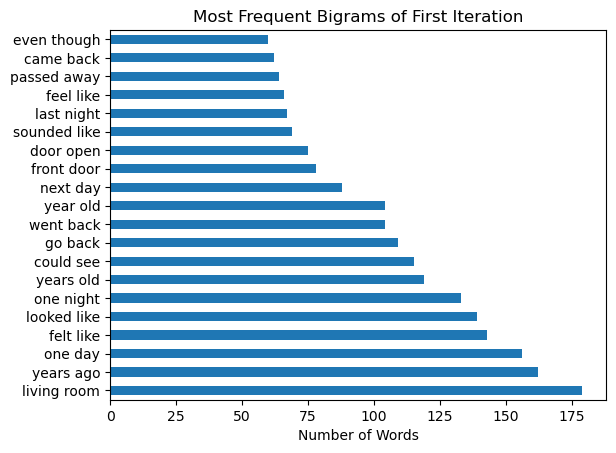

In [62]:
X_2_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Most Frequent Bigrams of First Iteration')
plt.xlabel('Number of Words');
plt.savefig('../images/first_it_bigrams.png')

In [46]:
def count_vec_3(data): 
    X = data['reg_text']
    y = data['subreddit']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    c_v_3 = CountVectorizer(stop_words=custom_stop, ngram_range=(3, 3))
    c_v_3.fit(X_train)
    X_3 = c_v_3.transform(X_train)
    X_3_df = pd.DataFrame(X_3.todense(), 
                          columns=c_v_3.get_feature_names_out())
    return X_3_df

In [47]:
X_3_df = count_vec_3(both_subs)

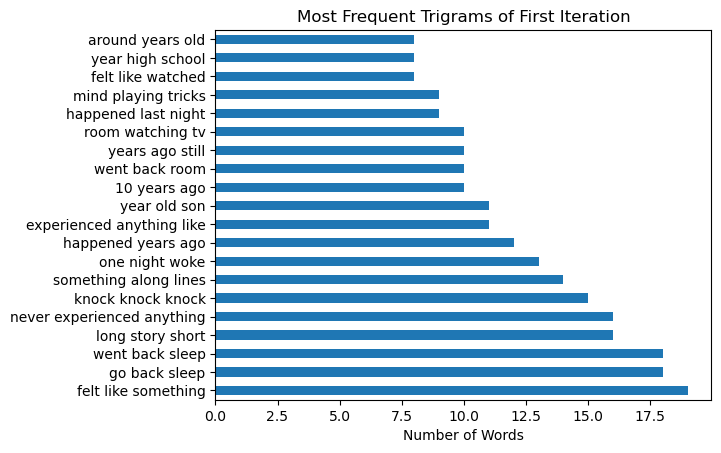

In [63]:
X_3_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Most Frequent Trigrams of First Iteration')
plt.xlabel('Number of Words');
plt.savefig('../images/first_it_trigrams.png')

- From our first iteration we can see unique phrases in our trigrams. I am happy with these results because some of these frequent phrases already have distinct characteristics that can hint to which subreddit it's from. Phrases such as 'knock knock knock' or 'woke middle night' I can infer are from the Ghoststories subreddit while others such as 'long story short' aren't as clear. 

In [49]:
text_sub_1 = pd.concat([X_1_df, both_subs['subreddit']], axis=1)

### Analyzing Word Frequency per Subreddit
- By looking at the most frequent words per subreddit, we can see a lot of overlap. Words such as 'just', 'like', 'time', 'said', 'room', and 'got' are the most frequent for both subreddits. These words are not distinct and tell us very little about either topic. In our second iteration we will additionally remove these words along with other tokenizing. 

In [50]:
funny_words_1 = text_sub_1[text_sub_1['subreddit'] == 0]
funny_words_1.drop(['subreddit'], axis=1).sum().sort_values(ascending=False).head(15)

just     1472.0
like     1438.0
room      988.0
time      945.0
house     875.0
said      711.0
got       708.0
night     642.0
door      633.0
day       592.0
went      591.0
didn      567.0
know      524.0
told      486.0
bed       476.0
dtype: float64

In [51]:
ghost_words_1 = text_sub_1[text_sub_1['subreddit'] == 1]
ghost_words_1.drop(['subreddit'], axis=1).sum().sort_values(ascending=False).head(15)

like       816.0
just       748.0
house      600.0
room       542.0
time       538.0
said       491.0
door       437.0
went       362.0
got        360.0
day        346.0
know       346.0
night      342.0
didn       293.0
told       276.0
started    273.0
dtype: float64

## Second Iteration 
- With Spacy we will filter our features by lemmatizing our posts and only extracting proper_nouns, verbs, adjectives, and nouns. This will be our harshest iterations with the least features. By comparing three different strengths of iteration we will be able to see which one performs the best. 

In [52]:
nlp = spacy.load('en_core_web_md')

In [53]:
both_subs['spacy_text'] = both_subs['title_text'].apply(lambda x:
        ' '.join([token.lemma_ for token in nlp(x.lower()) if token.pos_ in ('PROPN', 'VERB', 'ADJ', 'NOUN') and len(token.lemma_) >1]))

In [23]:
both_subs['spacy_text'][0]

'Mother Russian NeighbourSo story mine mother early 20 have pet cat name Octopus have russian neighbor live next door day reason pick cat go call Octopus cat see leg mom go neighbour say Octopus cat see leg cat no English pussy cat word cat call octo-**pus No no cat have leg count leg cat No pussy cat puss have leg HE CAT'

In [24]:
both_subs['title_text'][0]

'My Mother\'s Russian NeighbourSo this story isn\'t mine but my mother\'s from when she was in her early 20s.\n\nShe had a pet cat she named Octopus, she also had a Russian neighbor that lived next door. One day he\'s over for some reason and picks up her cat and goes "why you call him Octopus? He\'s cat! See, four legs!"\n\nAnd my Mom goes "Because. Octo-**pus**"\n\nThe neighbour then says "but he no Octopus he cat! See four legs, not eight. He cat"\n\n"No-no. In English, pussy cat is another word for cat. So I called him Octo-**pus**"\n\n"No-no he cat. He have 4 legs, count them. 1-2-3-4. Not 8, 4 legs, he cat!"\n\n"No. Octo-**pus**. Pussy cat, puss"\n\n"BUT HE HAVE FOUR LEGS. HE CAT!"'

### Most Common Words per Subreddit
- After filtering the most words with Spacy we will want to look at the amount of overlap that we are getting from the subreddits. 
- We can still see a fair amount of overlap however the overlapped words differ in frequency. We can also find unique words that seem to resemble the characteristics of their subreddits. 

**Unique Words**
- Ghoststories: 'room', 'house', 'hear', 'door', and 'night'
- funnystories: 'friend', 'day', 'story'

In [37]:
ghost_spacy_words = both_subs[both_subs['subreddit'] == 1]
funny_spacy_words = both_subs[both_subs['subreddit'] == 0]

In [38]:
ghost_spacy_fq = count_vec_1(ghost_spacy_words, 'spacy_text')
funny_spacy_fq = count_vec_1(funny_spacy_words, 'spacy_text')

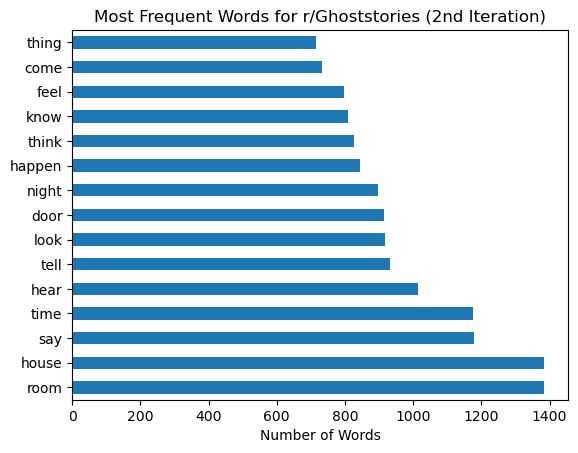

In [64]:
ghost_spacy_fq.sum().sort_values(ascending=False).head(15).plot(kind = 'barh');
plt.title('Most Frequent Words for r/Ghoststories (2nd Iteration)')
plt.xlabel('Number of Words');
plt.savefig('../images/second_it_ghost.png')

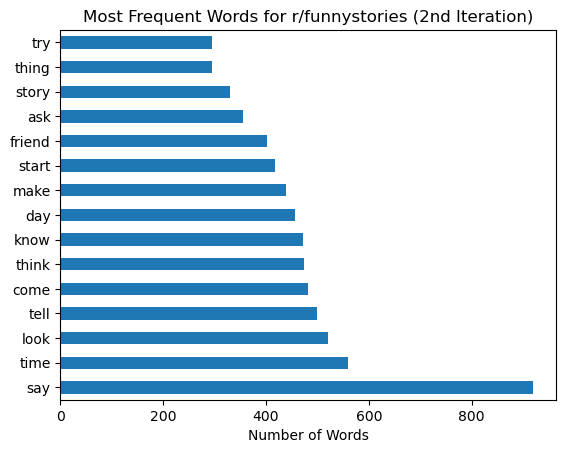

In [65]:
funny_spacy_fq.sum().sort_values(ascending=False).head(15).plot(kind = 'barh')
plt.title('Most Frequent Words for r/funnystories (2nd Iteration)')
plt.xlabel('Number of Words');
plt.savefig('../images/second_it_funny.png')

In [25]:
preprocessed = both_subs
preprocessed.to_csv('../data/preprocessed.csv', index=False)